In [1]:
%matplotlib inline

 <h1> Big-Data Analytics </h1>
 <h4> Group 25 </h4>
 

The goal of the project is to process a raw dataset from beginning to end, going through each of the steps in the data science pipeline. The ongoing Coronavirus crisis has upended not only our semester, but our lives, so our group could not think of a more fitting topic to examine with this project. Amidst the rapidly evolving threat, the most up-to-date sources have often been social media platforms online both for front-line ER doctors sharing clinical procedures (https://www.nytimes.com/2020/03/18/well/live/coronavirus-doctors-facebook-twitter-social-media-covid.html) and for the broader scientific community and reporters, sharing insights and ideas to combat the crisis. 

Its timeliness and reputation, as well as the company's relative openness to sharing data with developers via their API, made Twitter a logical source of data for this project.

Early in the crisis, many people (though populists most prominently, with their anti-expertise bias) the world over claimed "the media" was overreacting to the crisis, and sensationalizing the threat. While this interpretation has been clearly born out as false, our group is interested in how closely the "buzz" around the virus correlates with the actual rates of infection. Much has been made about the virus's exponential spread: do posts about the virus in affected regions follow the same pattern? How can we understand not only the patterns within countries but the differences between countries?

The deliverable of the project consists of a Jupyter notebook that includes the
code used for exploring, processing, analyzing, and visualizing the data set and
the data set itself (this can be download link). If the data set is very large, a
sample of the data set can also be appropriate. 

In [2]:
import json
import os
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt

<h1> Data collection/acquisition </h1>

This section is not meant to be run (and it also will not run because api keys etc. are missing). The following code is just meant to show the approach used to query the twitter api and to obtain the data we use in the following.

 ```python
import requests
import base64
import json
import time

base = 'https://api.twitter.com/1.1/tweets/search/'
#Define your keys from the developer portal
client_key = ''
client_secret = ''
#Reformat the keys and encode them
key_secret = '{}:{}'.format(client_key, client_secret).encode('ascii')

# Transform from bytes to bytes that can be printed
b64_encoded_key = base64.b64encode(key_secret)
#Transform from bytes back into Unicode
b64_encoded_key = b64_encoded_key.decode('ascii')

# Do first request manually and paste next_page here
next_page = ''


def auth():
    auth_headers = {
    'Authorization': 'Basic {}'.format(b64_encoded_key)
    }
    auth_data = {
        'grant_type': 'client_credentials'
    }
    auth_resp = requests.post('https://api.twitter.com/oauth2/token', headers=auth_headers, data=auth_data)
    token = auth_resp.json()['access_token']

    session = requests.Session()
    session.headers = {'Authorization': 'Bearer ' + token}
    return session


def get30daysNY(session):
    global next_page

    res = session.post('https://api.twitter.com/1.1/tweets/search/30day/dev.json', json={
        "query" : "place:NY (#COVID19 OR #COVID-19 OR #covid_19 OR #covid OR #corona OR #coronavirus)",
        "fromDate":"202003120000", 
        "toDate":"202004110000",
        "next": next_page
    })

    json_res = res.json()
    try:
        next_page = json_res['next']

    except:
        next_page = None

    print('next_page ', next_page)

    return json_res


def getArchiveNY(session):
    global next_page
    
    res = session.post('https://api.twitter.com/1.1/tweets/search/fullarchive/dev.json', json={
        "query" : "place:NY (#COVID19 OR #COVID-19 OR #covid_19 OR #covid OR #corona OR #coronavirus)",
        "fromDate":"202002120000", 
        "toDate":"202003120000",
        "next": next_page
    })

    json_res = res.json()
    try:
        next_page = json_res['next']

    except:
        next_page = None

    print('next_page ', next_page)

    return json_res


if __name__ == "__main__":
    session = auth()


    i = 2

    while True:
        # avoid rate limits
        time.sleep(5)
        # change the method to the one you want
        res = getArchiveNY(session)
        # res = get30daysNY(session)

        with open('ny-' + str(i) + '.json', 'w', encoding='utf-8') as f:
            json.dump(res, f, ensure_ascii=False, indent=2)

        i += 1

        if next_page == None:
            break
```

<h1> Data preprocessing/cleaning </h1>




In [3]:
#counts by region
#plotting day-by-day bar charts counting mentions?
#plotting on map of Italy with dot size showing the number of mentions

In [4]:
# dictionary for tweets per day
italia = {}
ny = {}


# array with name of all files in a folder
italia_json_files = []
ny_json_files = []

In [5]:
def get_all_filesname(files, state):
    if state == "italy":
        files = os.listdir('Data/twitter-data/IT') 
    elif state == "ny":
        files = os.listdir('Data/twitter-data/NY')
    return files
    
def date_collector(data_set, d):
    for i in data_set['results']:
        date = date_transformer(i['created_at'][4:10])
        if not date in list(d.keys()):
            d[date] = 1
        else:
            d[date] +=1

    return d

def files_walker(files, d, state):
    if state == "ny":
        for i in range(len(files)):
            with open('Data/twitter-data/NY/'+files[i], 'r', encoding='utf8', errors='ignore') as f:
                region = json.load(f)
                date_collector(region, d)
    elif state =="italy":
        for i in range(len(files)):
            with open('Data/twitter-data/IT/'+files[i], 'r', encoding='utf8', errors='ignore') as f:
                region = json.load(f)
                date_collector(region, d)
    return d

def date_transformer(string_data):
    date = string_data + ' 2020'
    return datetime.strptime(date,"%b %d %Y")


<h3> Italy </h3>

In [6]:
italia_json_files = get_all_filesname(italia_json_files, 'italy')
italia = files_walker(italia_json_files, italia, "italy")
df_italy = pd.DataFrame.from_dict(italia, orient= 'index')
df_italy_sorted = df_italy.sort_index()

<h3> New York </h3>

In [7]:
ny_json_files = get_all_filesname(ny_json_files, 'ny')
ny = files_walker(ny_json_files, ny,'ny')
df_ny = pd.DataFrame.from_dict(ny, orient= 'index')
df_ny_sorted = df_ny.sort_index()

# Exploratory Data Analysis

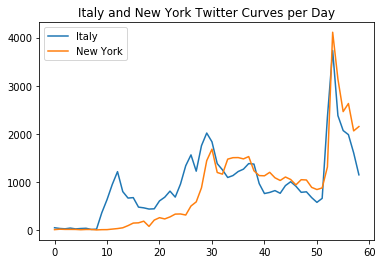

In [8]:
x = [i for i in range(len(df_italy_sorted[0]))]
plt.plot(x,df_italy_sorted[0], label = 'Italy')
plt.plot(x,df_ny_sorted[0], label = 'New York')
plt.title('Italy and New York Twitter Curves per Day')

plt.legend()
plt.show()

# Model/algorithm building

In [9]:
sentimental_ny = {}
ny_json_files = []

In [10]:
from textblob import TextBlob
import re
from googletrans import Translator

#sentiment analysis

def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analyze_sentiment(tweet):
    analysis= TextBlob(clean_tweet(tweet))
    
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

def sentimental_date_collector(data_set, d):
    for i in data_set['results']:
        date = date_transformer(i['created_at'][4:10])
        if not date in list(d.keys()):
            sentiment_dict = {'positive':0, 'neutral': 0, 'negative':0 }
            d[date] = sentiment_dict
        if i['lang'] == 'en':
            tweet = analyze_sentiment(i['text'])
            if tweet == 1:
                d[date]['positive'] += 1 
            elif tweet == -1:
                d[date]['negative'] += 1
            else:
                d[date]['neutral'] += 1
            
    return d

def sentiment_walker(files, d, state):
    if state == "ny":
        for i in range(len(files)):
            with open('Data/twitter-data/NY/'+files[i], 'r', encoding='utf8', errors='ignore') as f:
                region = json.load(f)
                sentimental_date_collector(region, d)
    elif state =="italy":
        for i in range(len(files)):
            with open('Data/twitter-data/IT/'+files[i], 'r', encoding='utf8', errors='ignore') as f:
                region = json.load(f)
                sentimental_date_collector_it(region, d)
    return d


In [11]:
ny_json_files = get_all_filesname(ny_json_files, 'ny')
sentimental_ny = sentiment_walker(ny_json_files, sentimental_ny,'ny')
df_ny_sentimental = pd.DataFrame.from_dict(sentimental_ny, orient= 'index')
df_ny_sensort = df_ny_sentimental.sort_index()

In [12]:
df_ny_sensort

,positive,neutral,negative
2020-02-12,6,4,3
2020-02-13,8,9,5
2020-02-14,6,6,6
2020-02-15,14,3,3
2020-02-16,11,5,2
2020-02-17,7,5,2
2020-02-18,11,6,0
2020-02-19,4,9,4
2020-02-20,6,1,2
2020-02-21,6,7,1


 # Data visualization & interpretation

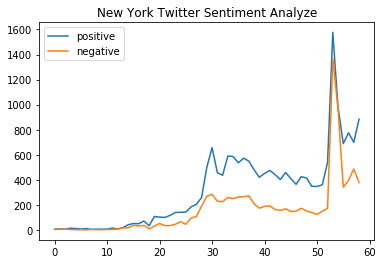

In [13]:
x = [i for i in range(len(df_ny_sensort))]
plt.plot(x,df_ny_sensort['positive'], label = 'positive')
#plt.plot(x,df_ny_sensort['neutral'], label = 'neutral')
plt.plot(x,df_ny_sensort['negative'], label = 'negative')
plt.title('New York Twitter Sentiment Analyze')

plt.legend()
plt.show()

<h3> What happened on 05.April 2020??? </h3>

In [14]:
#see how the rates correlate when we control for twitter DAU  & MAU (daily/monthly active users)